In [1]:
import qiskit.tools.jupyter

%qiskit_version_table

# The Quantum Autoencoder

The goal of this tutorial is to build an Quantum Autoencoder, a circuit which can compress a quantum state onto a smaller amount of qubits, while retaining the information from the initial state.

Throughout this tutorial, we explain the architecture of a Quantum Autoencoder and how one can design and train such a system to compress and encode information. Following this discussion, we give two examples to demonstrate the capabilities of such a system to compress different quantum states, as well as the ability to compress images of zeros and ones. 

## 1. What is an Autoencoder?

A classical autoencoder (CAE) is a type of neural network architecture that is commonly used to efficiently compress and encode information from the input using of representation learning. Following compression, one can then uncompress the data through the use of a decoder. 

Typical autoencoders are commonly divided into three layers, as seen in Figure 1. 

![qae_fig1_wide.png](qae_fig1_wide.png)
Figure 1: Example of a Classical Autoencoder which includes the input, bottleneck and output layer.
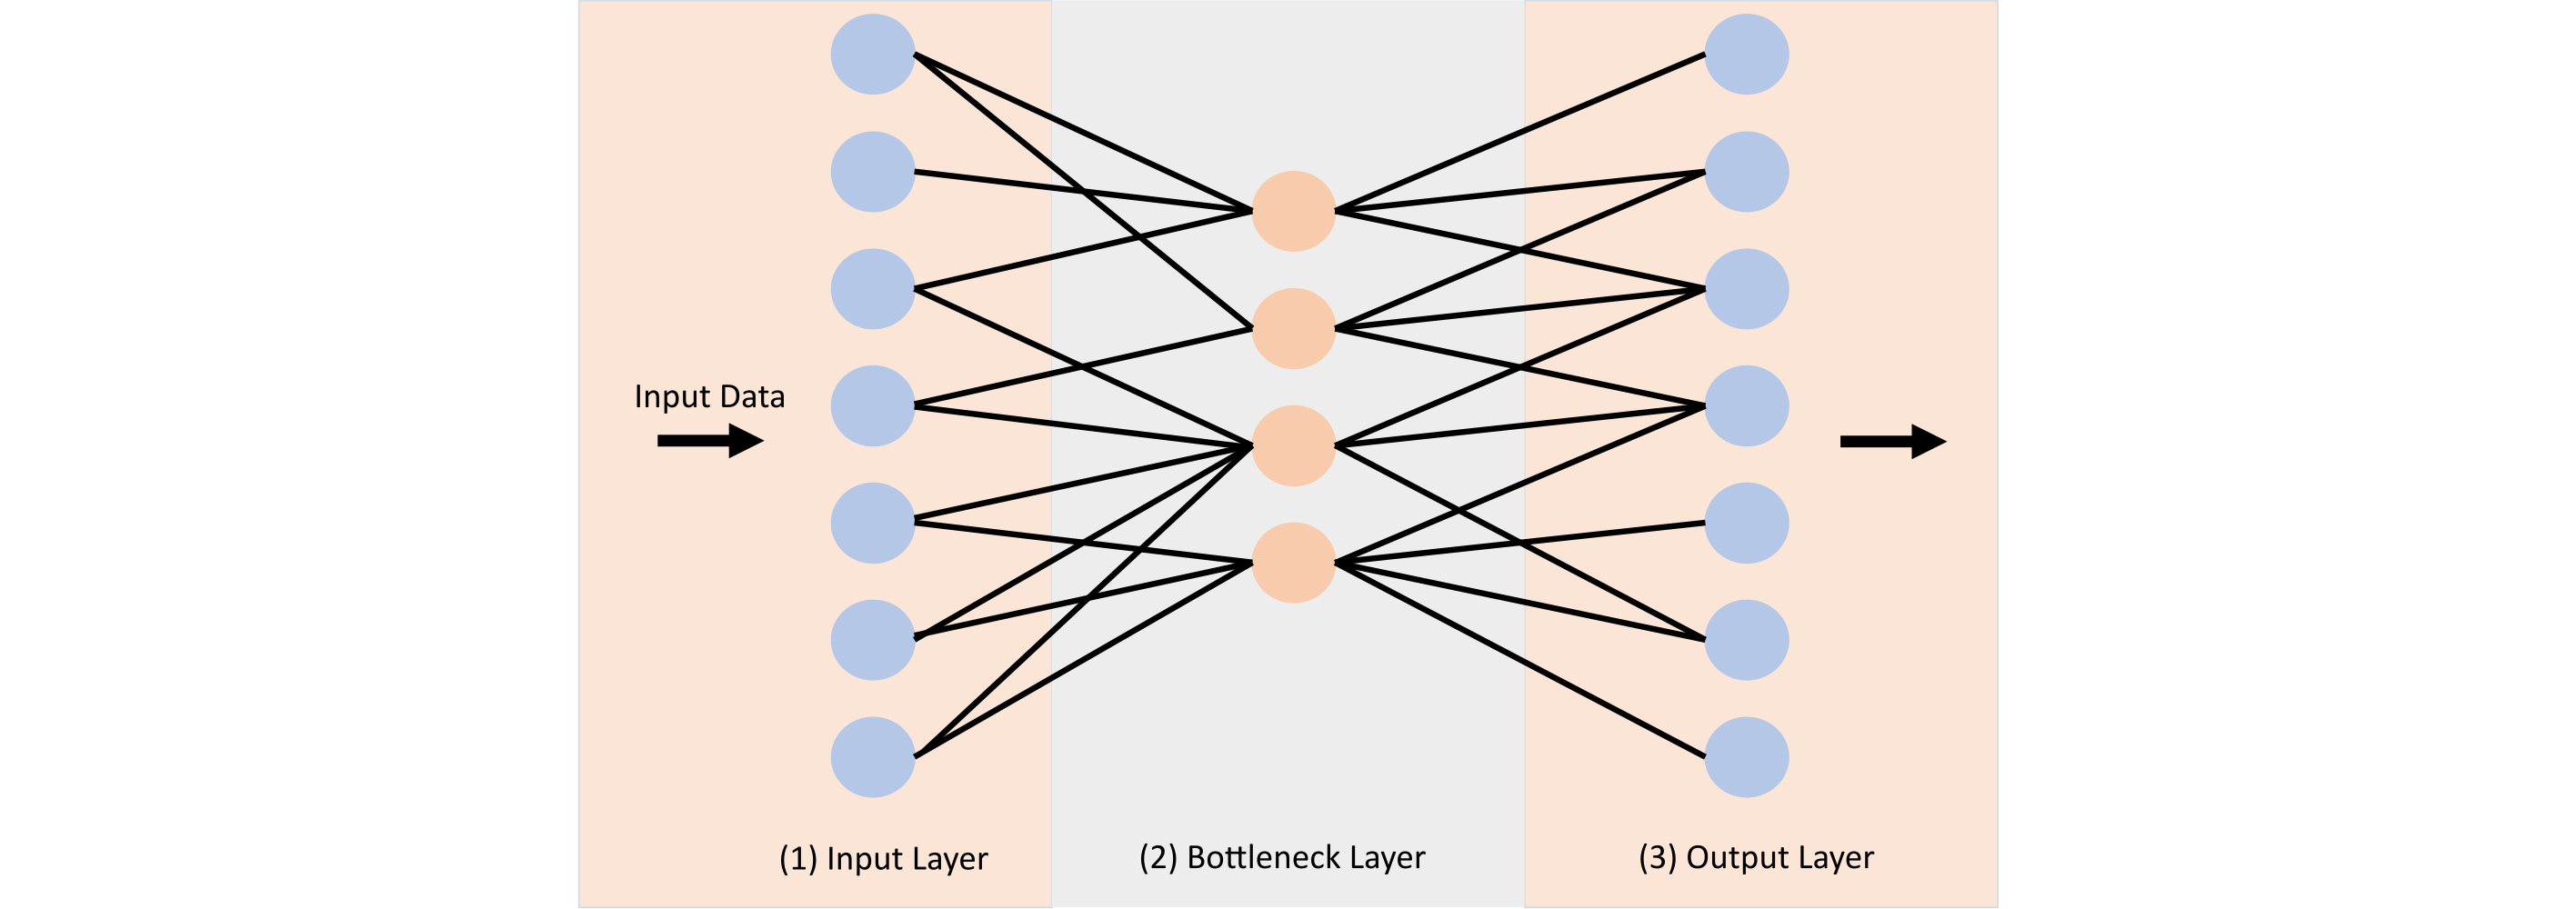

The first layer is called the Input Layer (1) and is the layer of which we input our data of length $n$. 

The input data then passes through an encoder and travels to the next layer, which has less nodes or is reduced in dimensions and is known as the Bottleneck Layer (2). The input layer is compressed through this process. Common CAEs may have several layers.

The final layer is called the Output Layer (3). Here the compressed data is reconstructed to its original size, $n$, from the compressed data through the process of a decoder. 

By passing our input data through a CAE, we are therefore able to reduce the dimensionality of our input data, as seen in the bottleneck layer, while retaining as much information as possible from the input data. Because of this feature, common uses of CAE are Image Denoising, Anomaly Detection and Facial Recognition devices. For more information on classical autoencoders, see [1].

## 2. The Quantum Autoencoder 

We can also define a quantum counterpart to the CAE, the Quantum Autoencoder. Much like the CAE, the Quantum Autoencoder aims to reduce the dimensionality of the input of the neural network, in this case a quantum state. A pictorial representation of this can be seen in Figure 2.

![qae_fig2_wide.png](qae_fig2_wide.png)
Figure 2: Pictorial Representation of a Quantum Autoencoder. Here one can see the similarities with the CAE, with the circuit having an input state, bottleneck state and an output state.
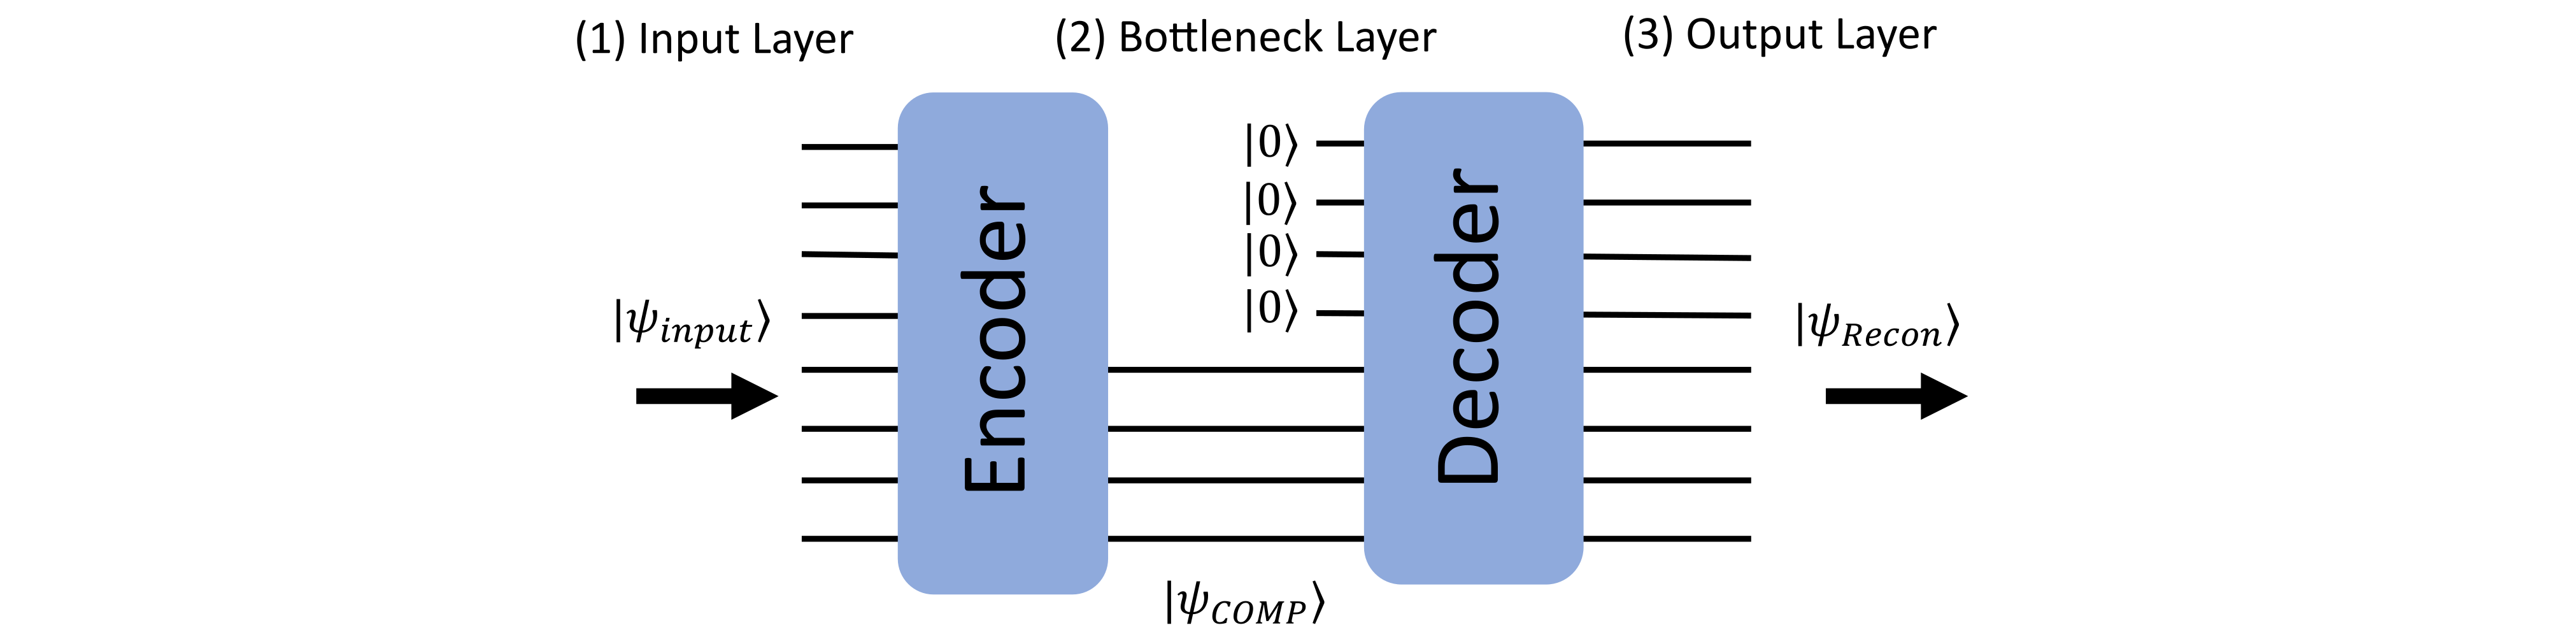

 

Much like its classical counterpart, our circuit contains three layers. We first input our state $|\psi>$ (which contains $n$ qubits), of which we wish to compress. This is our input layer (1). 

We then apply our parametrized circuit on our input state, which will act as our encoder and 'compresses' our quantum state, reducing the dimensionality of our state to $n-k$ qubits. Our new compressed state is of the form $|\psi_{comp}> \otimes |0>^{\otimes k}$, where $|\psi_{comp}>$ contains $n-k$ qubits. 

This parametrized circuit will depend on a set of parameters, which will be the nodes of our Quantum Autoencoder. Throughout the training process, these parameters will be updated to optimize the loss function. 

We disregard the remaining $k$ qubits for the remainder of the circuit. This is our bottleneck layer (2) and our input state is now compressed. 

The final layer consists of the addition of $k$ qubits (all in the state $|0\rangle$) and applying another parametrized circuit between the compressed state and the new qubits. This parametrized circuit acts as our decoder and reconstructs the input state from the compressed state using the new qubits. After the decoder, we retain the original state as the state travels to the output layer (3).

## 3. Components of a Quantum Autoencoder

Before building our Quantum Autoencoder, we must note a few subtleties.

We first note that we cannot introduce or disregard qubits in the middle of a Quantum Circuit when implementing an autoencoder using Qiskit. 

Because of this we must include our reference state as well as our auxiliary qubits (whose role will be described in later sections) at the beginning of the circuit. 

Therefore our input state will consist of our input state, reference state and one auxiliary qubit, as well as a classical register to perform measurements (which will be described in the next section). A pictorial representation of this can be seen in Figure 3. 

![qae_fig3_wide.png](qae_fig3_wide.png)
Figure 3: Pictorial Representation of input state of Quantum Autoencoder. Note that we must also include an auxiliary qubit, the reference state and classical register at the beginning of the circuit, even though they are not used until later in the circuit.
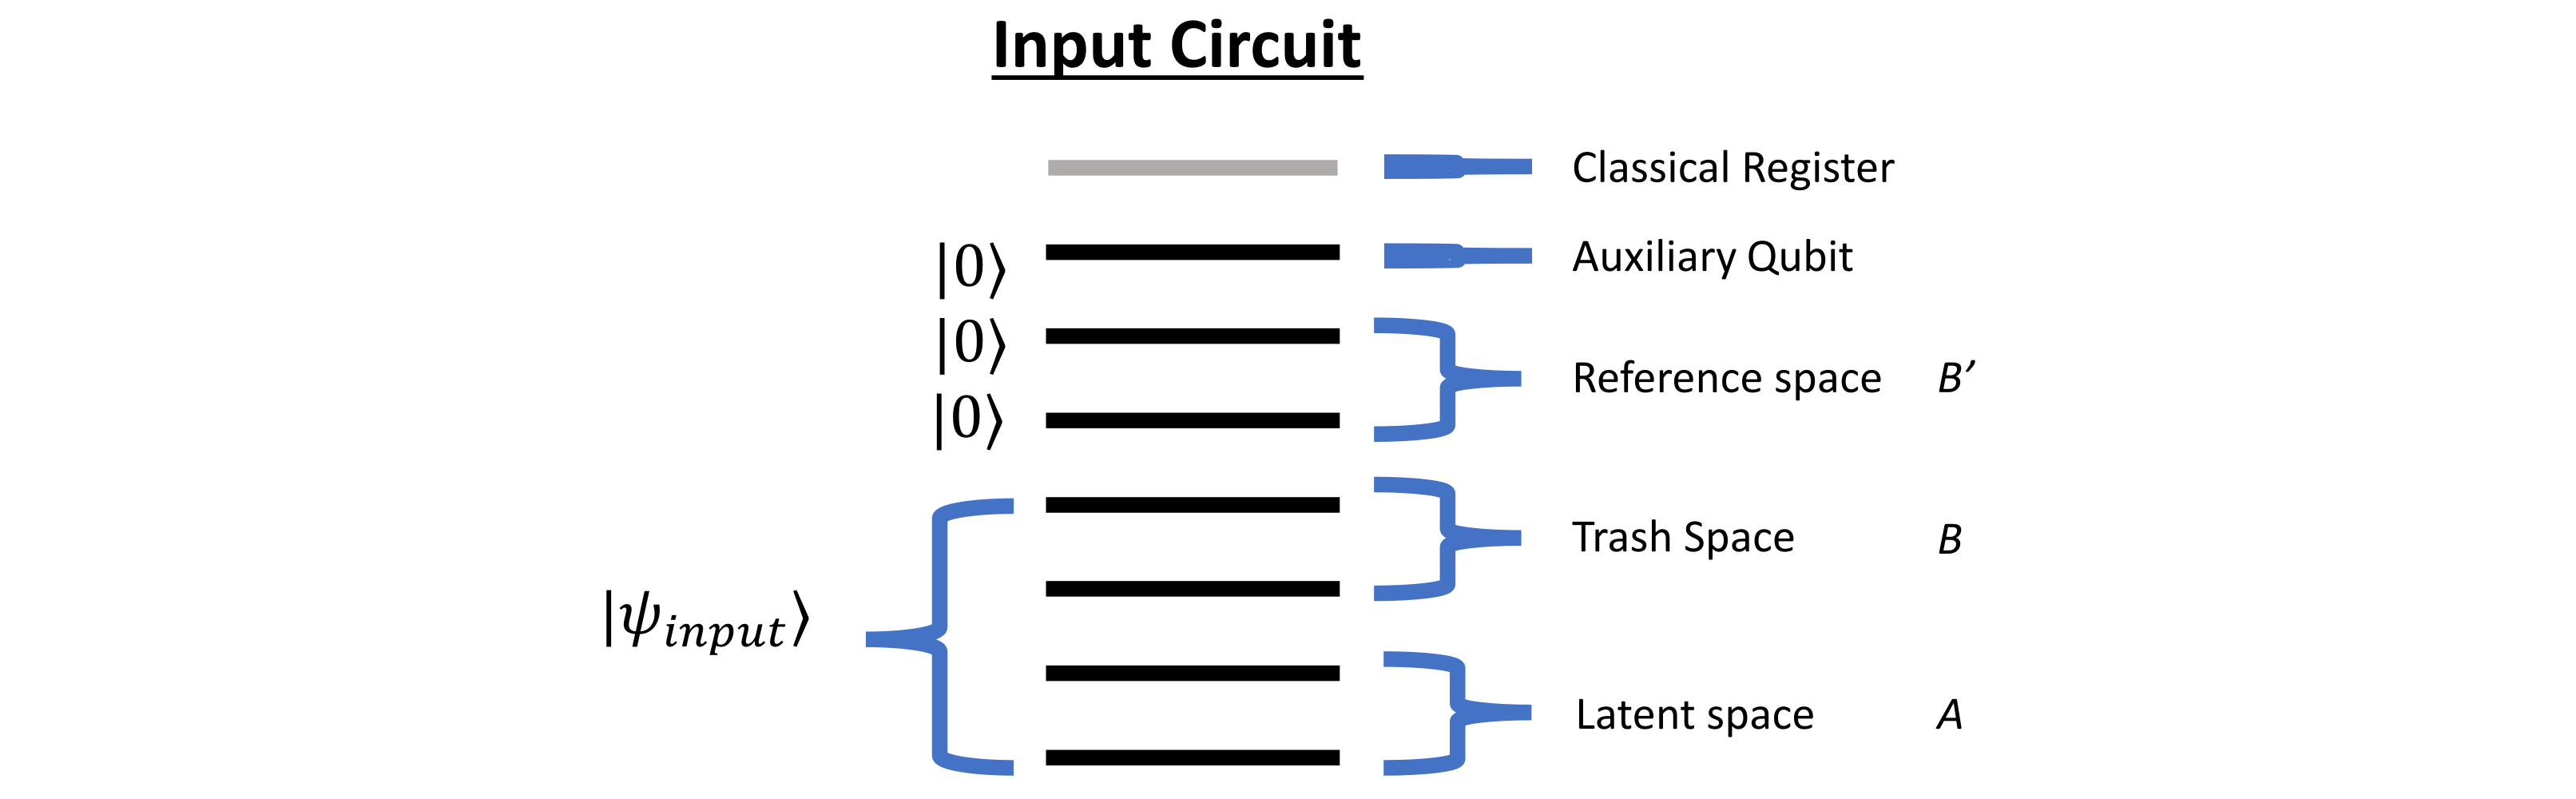

## 4. Choosing a Loss Function 

We now define our cost function, which we will use to train our Quantum Autoencoder, to return the input state. There's a bit of math involved here, so skip this section if you're not interested! 

We take the cost function as defined in [2], which tries to maximize the fidelity between the input and output state of our Quantum Autoencoder. 

We first define subsystems $A$ and $B$ to contain $n$ and $k$ qubits respectively, while $B'$ is the space which will contain our reference space. We call the subsystem $A$ our latent space, which will contain the compressed qubit state, and $B$ our trash space, which contain the qubits of which we disregard throughout compression. 

Our input state therefore $|\psi_{AB}>$ contains $n + k$ qubits. We define the reference space $B'$ which contains the reference state $|a>_{B'}$. This space will contain the additional $k$ qubits we use in the decoder. All of these subsystems can be seen in Figure 3. 

We define the parameterized circuit as $U(\theta)$ which we will use as our encoder. However the structure and parameters of our parametrized circuit is currently unknown to us and may vary for different input states. To determine the parameters to compress our input state, we must train our device to maximally compress the state by adjusting the values of the parameters $\theta$. For the decoder we will use $U^{\dagger}(\theta)$.

Our goal therefore is to maximize the fidelity between the input and output states, i.e.

$$\text{max }F(\psi_{AB}, \rho_{out})$$

where

$$\rho_{out} = U^{\dagger}(\theta)_{AB'} \text{Tr}_{B} [U(\theta)_{AB}[\psi_{AB} \otimes a_{B'}]U^{\dagger}(\theta)_{AB}]U(\theta)_{AB'}$$

We can maximize this fidelity by tuning the parameters $\theta$ in our parametrized circuit. However, this fidelity can at times be complicated to determine and may require a large amount of gates needed to calculate the fidelity between two states, i.e. the larger the number of qubits, the more gates required which results to deeper circuits.  Therefore we look for alternative means of comparing the input and output states. 

As shown in [2] a simpler way of determining an optimally compressed state is to perform a swap gate between the trash state and reference state. These states usually have a smaller number of qubits and are therefore easier to compare, due to the smaller amount of gates required. As shown in [2] maximizing the fidelity of such these two states is equivalent to maximizing the fidelity of the input and output state and thus determining an optimal compression of our input circuit. 

Keeping our reference state fixed, our cost function will now be a function of the trash state and is denoted as; 

$$\text{max }F(\text{Tr}_{A} [ U(\theta)_{AB}\psi_{AB} U^{\dagger}(\theta)_{AB}], a_{B'})$$

Throughout the training process, we adjust the parameters $\theta$ in our encoder and perform a swap test (as described below) to determine the fidelity between these trash and reference states. In doing so, we must include an additional qubit, our auxiliary qubit, which will be used throughout the swap test and measured to determine the overall fidelity of the trash and reference states. This is the reason why we included both an auxiliary qubit and classical register in the previous section when initializing our circuit.  

### The SWAP Test

The SWAP Test is a procedure commonly used to compare two states by applying CNOT gates to each qubit (for further information see [3]). By running the circuit $M$ times, and applying the SWAP test, we then measure the auxiliary qubit. We use the number of states in the state $|1\rangle$ to compute:

$$S = 1 - \frac{2}{M}L$$

where $L$ is the count for the states in the $|1\rangle$ state. As shown in [3], maximizing this function corresponds to the two states of which we are comparing being identical. We therefore aim to maximize this function, i.e. minimize  $\frac{2}{M}L$. This value will be therefore be our cost function.

## 5. Building the Quantum Autoencoder Ansatz

First, we implement IBM's Qiskit to build our Quantum Autoencoder. We first begin by importing in the necessary libraries and fixing the seed.

In [2]:
import json
import time
import warnings
import numpy as np
import math
import qiskit
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


algorithm_globals.random_seed = 42

We begin by defining our parametrized ansatz for the Quantum Autoencoder. This will be our parametrized circuit where we can tune the parameters to maximize the fidelity between the trash and reference states. 

### The Parametrized Circuit 

The parametrized circuit we will use below for our encoder is the RealAmplitude Ansatz available in Qiskit. One of the reasons why we have chosen this ansatz is because it is a 2-local circuit, the prepared quantum states will only have real amplitudes, and does not rely on full connectivity between each qubits, which is hard to implement or can lead to deep circuits. 

We define our parametrized circuit for our Encoder below, where we set the repetition parameter to `reps=5`, to increase the number of parameters in our circuit allowing greater flexibility. 

In [3]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

Let's draw this ansatz with $5$ qubits and see what it looks like.

/home/obm/Prog/miniconda3/envs/Phys710/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


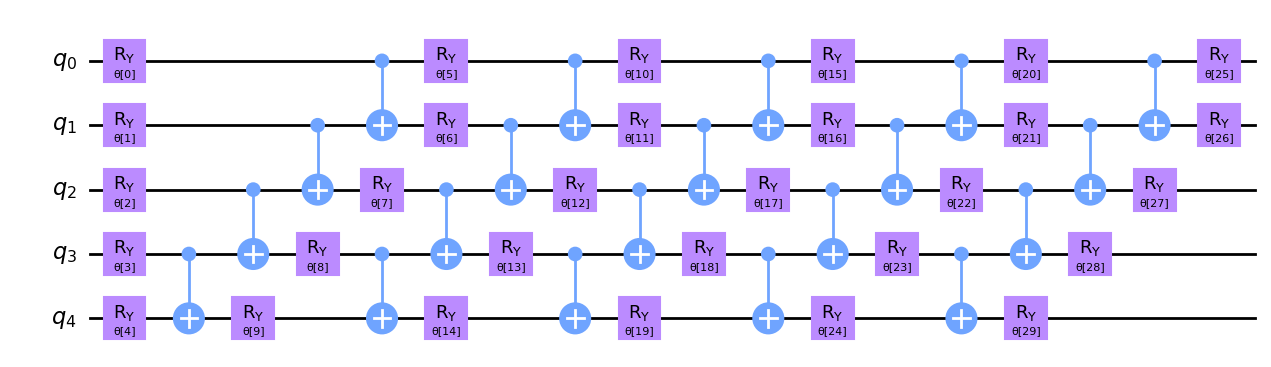

In [4]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

We now apply this Encoder to the state we wish to compress. In this example, we divide our initial $5$ qubit state into a $3$ qubit latent state ($n = 3$) and $2$ qubit trash space ($k = 2$). 

As explained in the previous section, we must also include a $2$ qubit reference space in our circuit, as well as an auxiliary qubit to perform the swap test between the reference and trash states. We will therefore have a total of $2 + 3 + 2 + 1 = 8$ qubits and $1$ classical register in our circuit.

After initializing our state, we apply our parametrized circuit.

Following this, we then split our initial state into the latent space (the compressed state) and trash space (the part of the state we will disregard) and perform the swap test between the reference state and the trash space. The last qubit is then measured to determine the fidelity between the reference and trash states.  A pictorial representation of this is given below in Figure 4. 

![qae_fig4_wide.png](qae_fig4_wide.png)
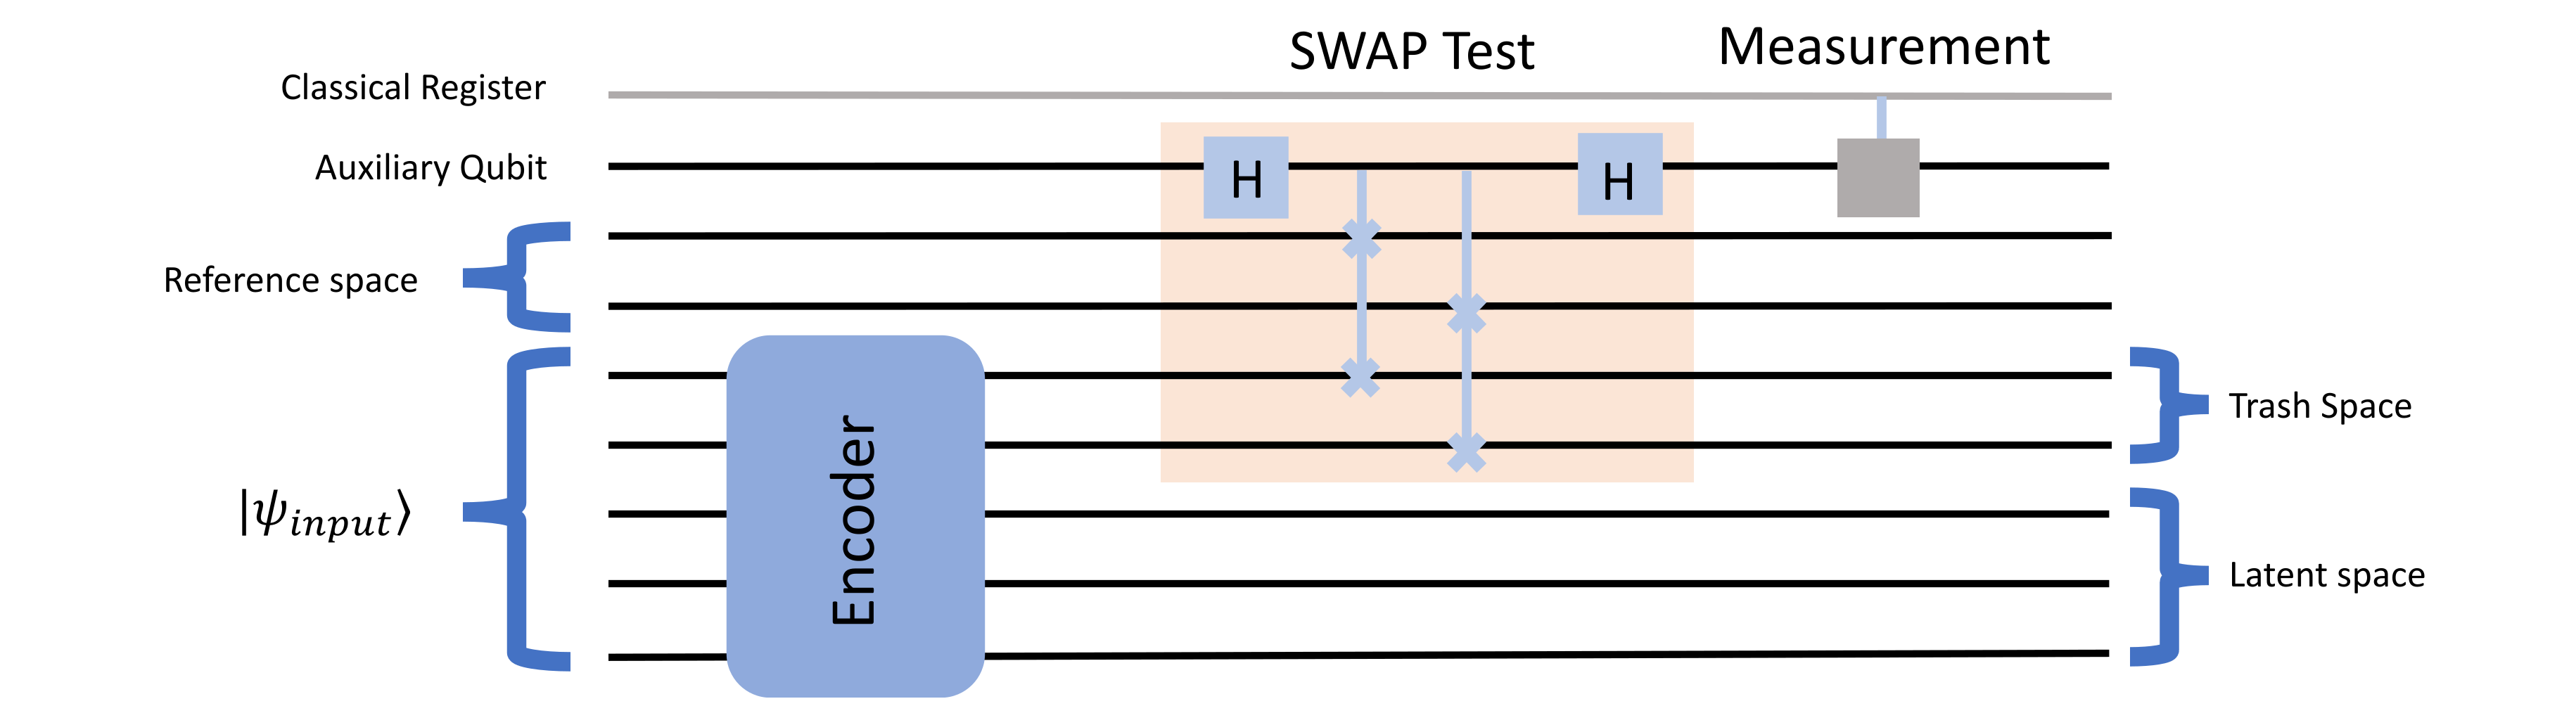

Figure 4: Example of a Quantum Autoencoder in the training process. We use the swap test to determine the fidelity between the trash and reference space. 

We define a function below to implement the above circuit configuration to the $5$ qubit domain wall state $|00111\rangle$ and plot an example below. Here qubits $5$ and $6$ are the reference state, $0, 1, 2, 3, 4$ are the initial state we wish to compress and qubit $7$ is our auxiliary qubit which is used in the swap test. We also include a classical register to measure the results of qubit $7$ in the swap test. 

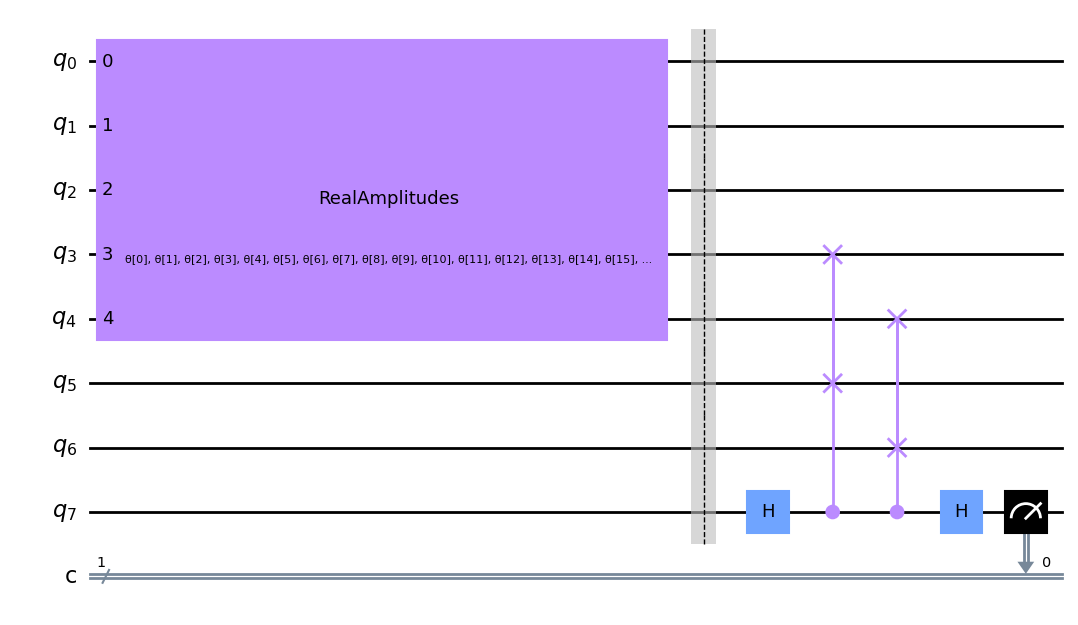

In [5]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw("mpl")

In order to reconstruct the original input state, we must apply the adjoint of our parametrized circuit after the swap test. However, during training, we are only interested in the trash state and the reference state. We can therefore exclude the gates following compression until we wish to reconstruct our initial input. 

After building our Quantum Autoencoder, the next step is to train our Quantum Autoencoder to compress the state and maximize the cost function and determine the parameters $\theta$. 

## 6. A Simple Example: The Domain Wall Autoencoder

Let's first begin with a simple example, a state known as the Domain Wall, which for $5$ qubits is given by $|00111\rangle$. Here we will try and compress this state from $5$ qubits to $3$ qubits, with the remaining qubits in the trash space, in the state $|00\rangle$. We can create a function to build the domain wall state below.

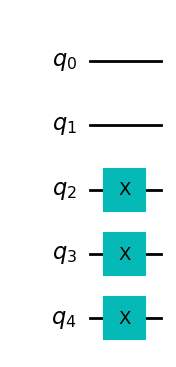

In [6]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl")

Now let's train our Autoencoder to compress this state from 5 qubits to 3 qubits (qubits 0,1 and 2), with the remaining qubits in the trash space (qubits 3 and 4) being in the |00> state. 

We create a circuit to be used in the loss function, as described in Section 4, which determines the fidelity between the two states below using the swap test for our particular AutoEncoder function. For further information on the swap test, see [1]. 

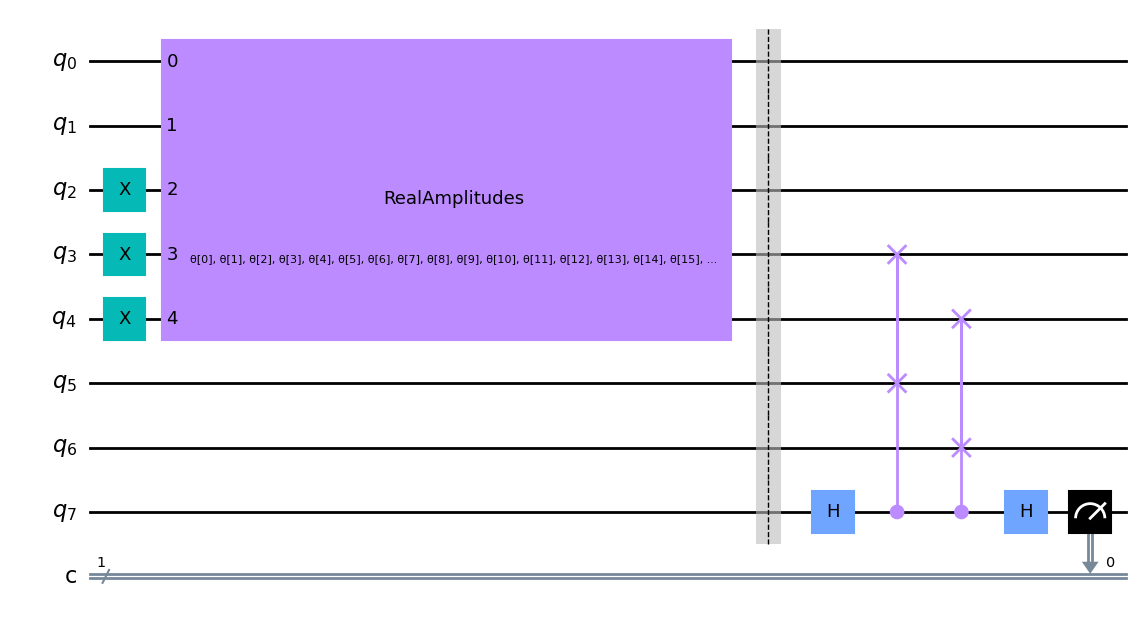

In [7]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw("mpl")

Then, we create a quantum neural network and pass the circuit as a parameter. We note that this network must take an interpret function, which determines how we map the output of the network to the output shape. Since we measure only one qubit, the output of the network is a bit string either $0$ or $1$, so the output shape is $2$, the number of possible outcomes. Then, we introduce an identity mapping. The output of the network is a vector of probabilities of getting interpret-mapped bit strings. Thus, we get probabilities of getting $0$ or $1$ and this is exactly what we are looking for. In the cost function we make use of the probability of getting $1$ and penalize the outcomes that lead to $1$, therefore maximizing the fidelity between the trash space and the reference space.

In [8]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

Next we create our cost function. As described in the previous section, our aim is to minimize $\frac{2}{M}L$, which is the twice the probability of getting the final qubit in the $|1\rangle$ state. We therefore wish to minimize the of getting a $|1\rangle$ on qubit 7.

The cost function will also plot out the objective value at each cost function evaluation.

In [9]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

Now we will train our Autoencoder to reduce the dimension of the Hilbert space from $5$ qubits to $3$, while leaving the trash space in the state $|00\rangle$.  We initially set the parameters $\theta$ to random values and tune these parameters to minimize our cost function through the use of the COBYLA optimizer. 

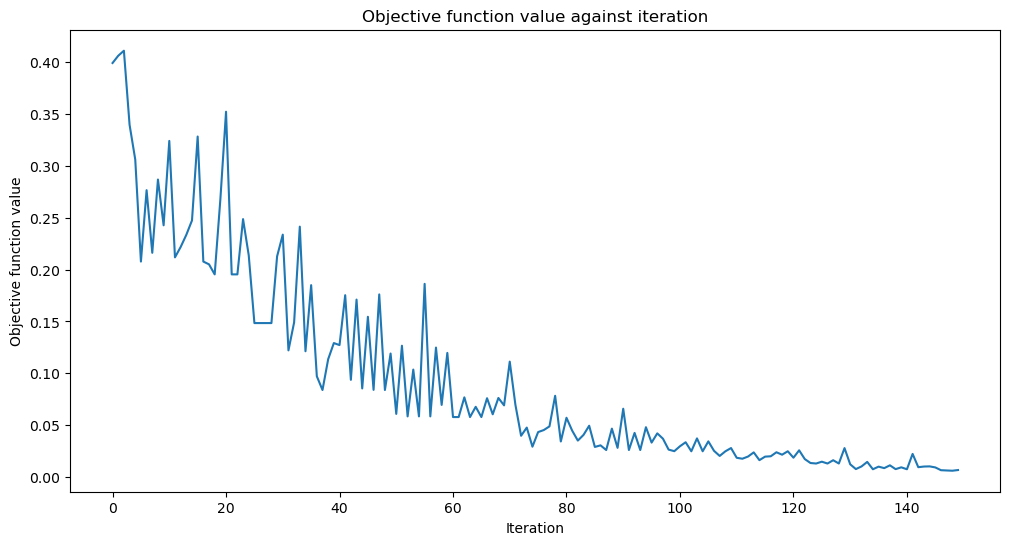

Fit in 19.61 seconds


In [10]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

Looks like it has converged! After training our Quantum Autoencoder, let's build it and see how well it compresses the state! 

To do this, we first apply our Autoencoder to a $5$ qubit Domain Wall state. After applying this state, the compressed state should be of the form $|00\rangle$. Therefore resetting the last two qubits should not effect our over all state. 

After resetting we apply our decoder (the hermitian conjugate of our encoder) and compare it to the initial state by determining the fidelity. If our fidelity is one, then our Autoencoder has encoded all the information of the domain wall efficiently into a smaller set of qubits and when decoding, we retain the original state! 

Let's first apply our circuit to the Domain Wall State, using the parameters we obtained when training our Quantum Autoencoder. (Note we have included barriers in our circuit below, however these are not necessary for the implementation of the Quantum Autoencoder and are used to determine between different sections of our circuit). 

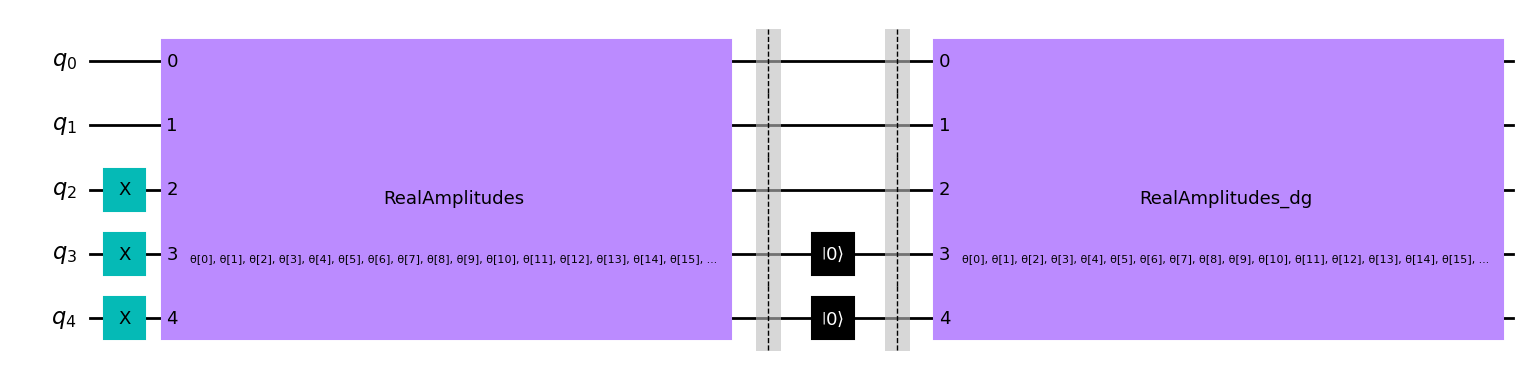

In [11]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw("mpl")

Now we assign the parameter values obtained in the training.

In [12]:
test_qc = test_qc.assign_parameters(opt_result.x)

Now let's get the statevectors of our Domain Wall state and output circuit and calculate the fidelity! 

In [13]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.9938652877745133


As you can see our fidelity is quite high and our Autoencoder has thus compressed our dataset while retaining all the information from the input state!

Now we will see if we can apply such a Quantum Autoencoder to more complicated datasets containing noise, such as images of the numbers zero and one. 

## 7. A Quantum Autoencoder for Digital Compression

One can also apply a Quantum Autoencoder to more complicated examples, such as a set of handwritten digits in order to compress the dataset. Below, we will show that we can indeed train an Quantum Autoencoder to compress such an example, giving us the ability to store data more efficiently on a Quantum Computer. 

For this tutorial, we will build a Quantum Autoencoder for a noisy dataset containing zeros and ones, which can be seen below. 

Each image contains $32$ pixels of which can be encoded into $5$ qubits by Amplitude Encoding. This can be done using Qiskit Machine Learning's `RawFeatureVector` feature map.  

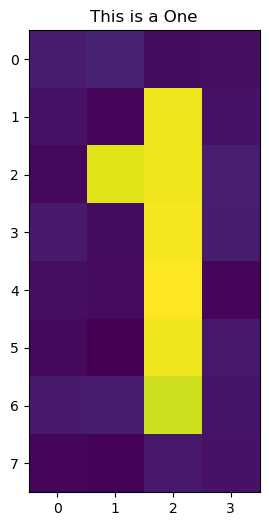

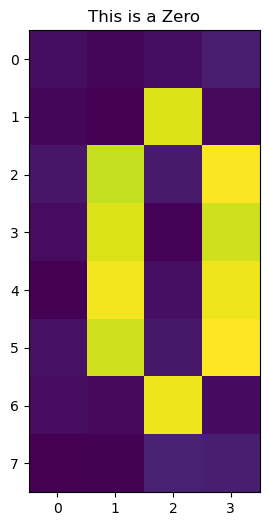

In [14]:
def zero_idx(j, i):
    # Index for zero pixels
    return [
        [i, j],
        [i - 1, j - 1],
        [i - 1, j + 1],
        [i - 2, j - 1],
        [i - 2, j + 1],
        [i - 3, j - 1],
        [i - 3, j + 1],
        [i - 4, j - 1],
        [i - 4, j + 1],
        [i - 5, j],
    ]


def one_idx(i, j):
    # Index for one pixels
    return [[i, j - 1], [i, j - 2], [i, j - 3], [i, j - 4], [i, j - 5], [i - 1, j - 4], [i, j]]


def get_dataset_digits(num, draw=True):
    # Create Dataset containing zero and one
    train_images = []
    train_labels = []
    for i in range(int(num / 2)):
        # First we introduce background noise
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the one
        for i, j in one_idx(2, 6):
            empty[j][i] = algorithm_globals.random.uniform(0.9, 1)
        train_images.append(empty)
        train_labels.append(1)
        if draw:
            plt.title("This is a One")
            plt.imshow(train_images[-1])
            plt.show()

    for i in range(int(num / 2)):
        empty = np.array([algorithm_globals.random.uniform(0, 0.1) for i in range(32)]).reshape(
            8, 4
        )

        # Now we insert the pixels for the zero
        for k, j in zero_idx(2, 6):
            empty[k][j] = algorithm_globals.random.uniform(0.9, 1)

        train_images.append(empty)
        train_labels.append(0)
        if draw:
            plt.imshow(train_images[-1])
            plt.title("This is a Zero")
            plt.show()

    train_images = np.array(train_images)
    train_images = train_images.reshape(len(train_images), 32)

    for i in range(len(train_images)):
        sum_sq = np.sum(train_images[i] ** 2)
        train_images[i] = train_images[i] / np.sqrt(sum_sq)

    return train_images, train_labels


train_images, __ = get_dataset_digits(2)

After encoding our image into $5$ qubits, we begin to train our Quantum Autoencoder to compress this state into $3$ qubits.

We repeat the steps in the previous example and write a cost function, again based on the Swap Test between the trash and latent space. We can also use the same Autoencoder function as given in the previous example, as the input state and trash space contain the same amount of qubits. 

Let's input one of our digits and see our circuit for the Autoencoder below. 

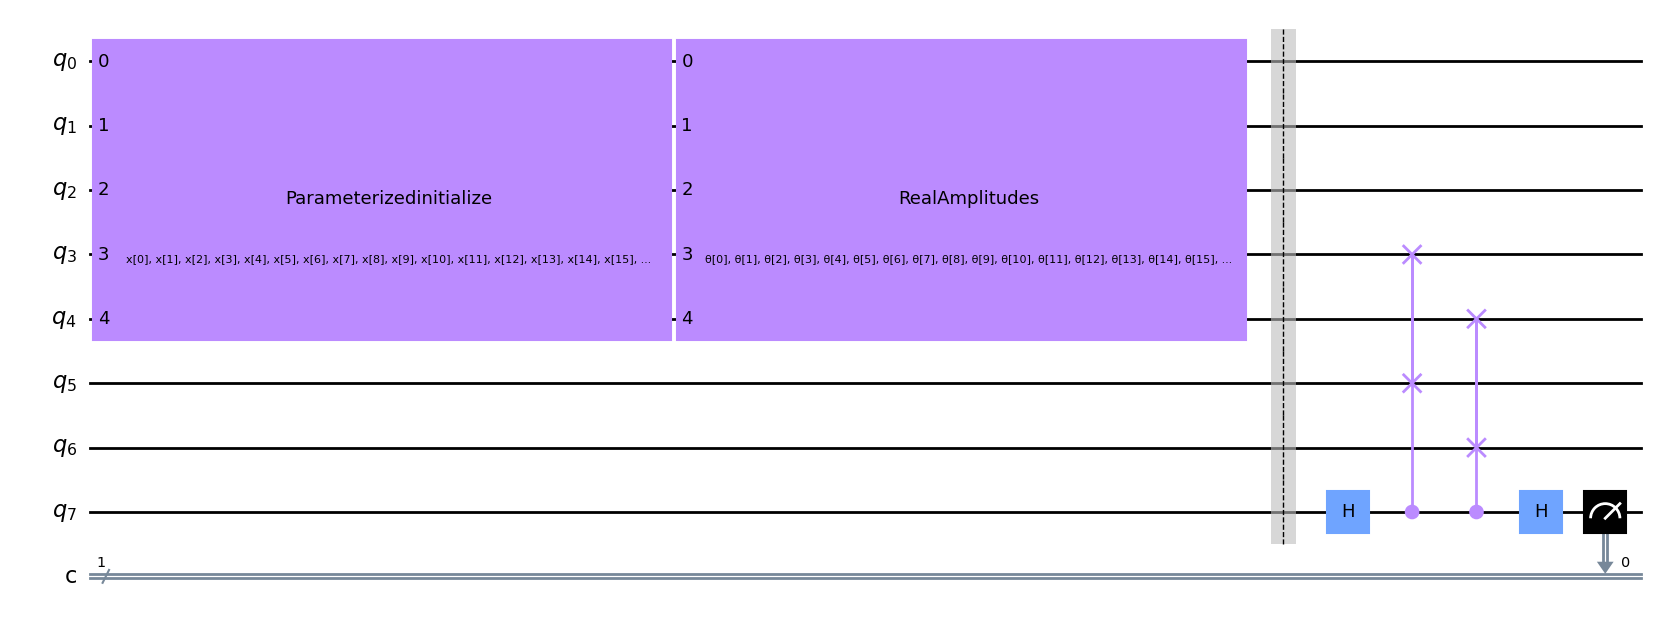

In [15]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl")

Again, we can see the swap test being performed on the qubits $3$, $4$, $5$ and $6$, which will determine the value of our cost function.

In [16]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

We build our cost function, based on the swap test between the reference and trash space for the digit dataset. To do this, we again use Qiskit Machine Learning's SamplerQNN network and use the same interpret function as we are measuring the probability of getting the final qubit in the $|1\rangle$ state.

In [17]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

Since model training may take a long time we have already pre-trained the model for some iterations and saved the pre-trained weights. We'll continue training from that point by setting `initial_point` to a vector of pre-trained weights.

In [18]:
with open("qae_initial_point.json", "r") as f:
    initial_point = json.load(f)

By minimizing this cost function, we can thus determine the required parameters to compress our noisy images. Let's see if we can encode our images! 

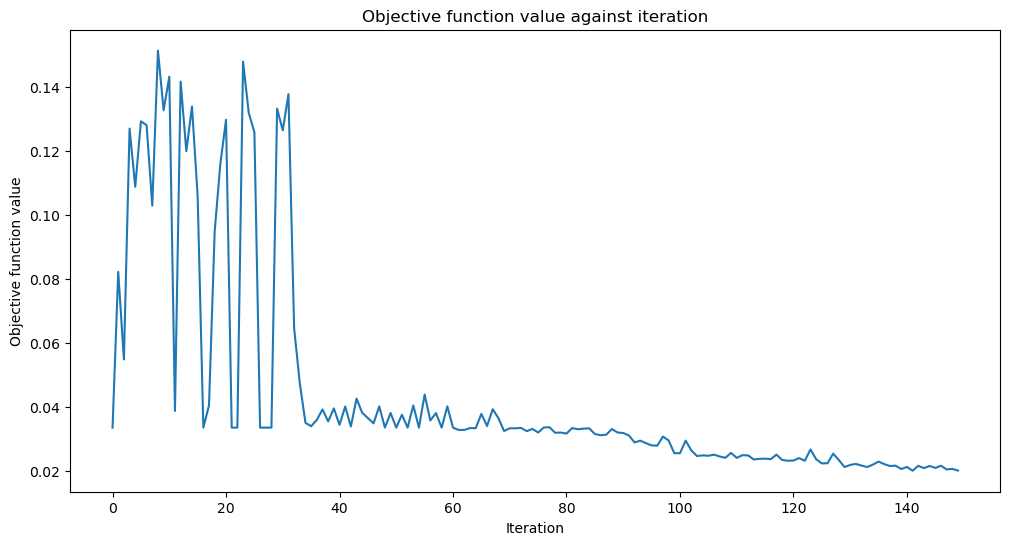

Fit in 16.06 seconds


In [19]:
opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

Looks like it has converged!

Now let's build our Encoder and Decoder using the parameters obtained from the training period. After applying this circuit to our new dataset, we can then compare our input and output data and see if we were able to retain the images efficiently throughout the compression! 

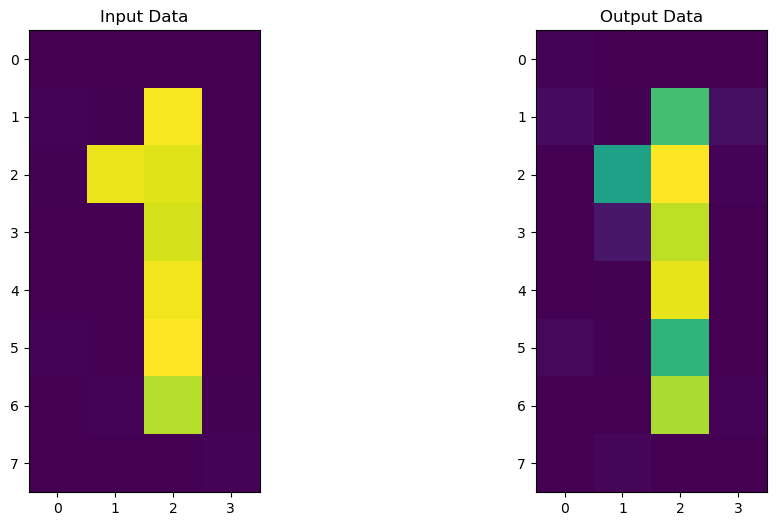

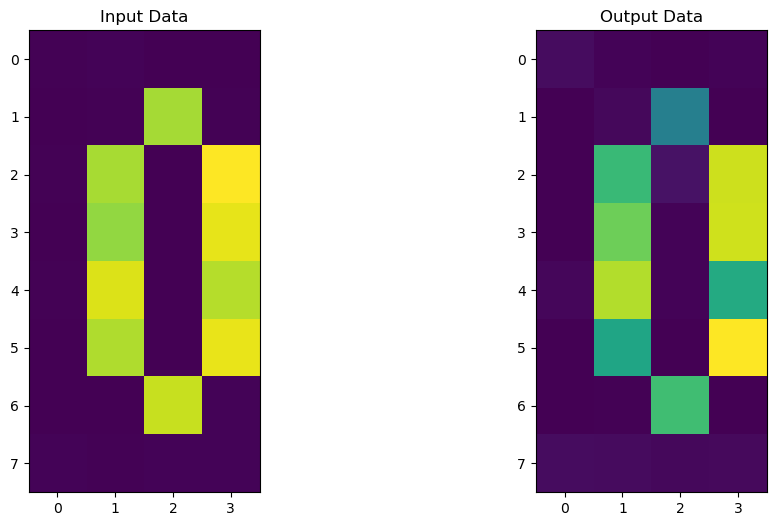

In [20]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()

It looks like our Quantum Autoencoder can be trained to encode digits as well! Now it's your turn to build your own Quantum Autoencoder and come up with ideas and datasets to compress!

## 8. Applications of a Quantum Autoencoder

Quantum Autoencoder's can be used for various different applications, including

1. Digital Compression: where information can be encoded into a smaller amount of qubits. This can be hugely beneficial for near term quantum devices, as smaller systems of qubits are less prone to noise.
2. Denoising: where one can use Quantum Autoencoder to extract relevant features from the initial quantum state or encoded data, while neglecting any additional noise.
3. Quantum Chemistry: in which a Quantum Autoencoder can be used as an ansatz for systems, such as the Hubbard Model. This is commonly used to describe electron-electron interactions in molecules. 

# Generate random quantum circuit states 

- Through arbitrary rotations and entangling gates

In [21]:
def normalize(d, target=1.0):
   raw = sum(d.values())
   factor = target/raw
   return {key:value*factor for key,value in d.items()}
   
def conv_resultdict_nparray(results:dict, nqubits:int) -> np.ndarray:
    """Convert quantum circuit results (dict) into a 2D matrix
    that stores all the binary vectors.
    First we get all the strings obtained for each measurement (m) and then convert each bitstring into
    a n-column vector. Such a vector is created for each measurement, yielding a 2D matrix (m, n)"""
    
    result_array_str = np.concatenate([[key]*results[key] for key in results])
    result_array_vec = np.zeros((result_array_str.shape[0], nqubits))
    for rowid, row in enumerate(result_array_str):
        for colid, elem in enumerate(row):
            result_array_vec[rowid-1, colid-1] = elem

    print("Result loaded on numpy array! Output shape:",(result_array_vec.shape))
    return np.random.permutation(result_array_vec)

In [22]:
nqubits = 4
seed = 12

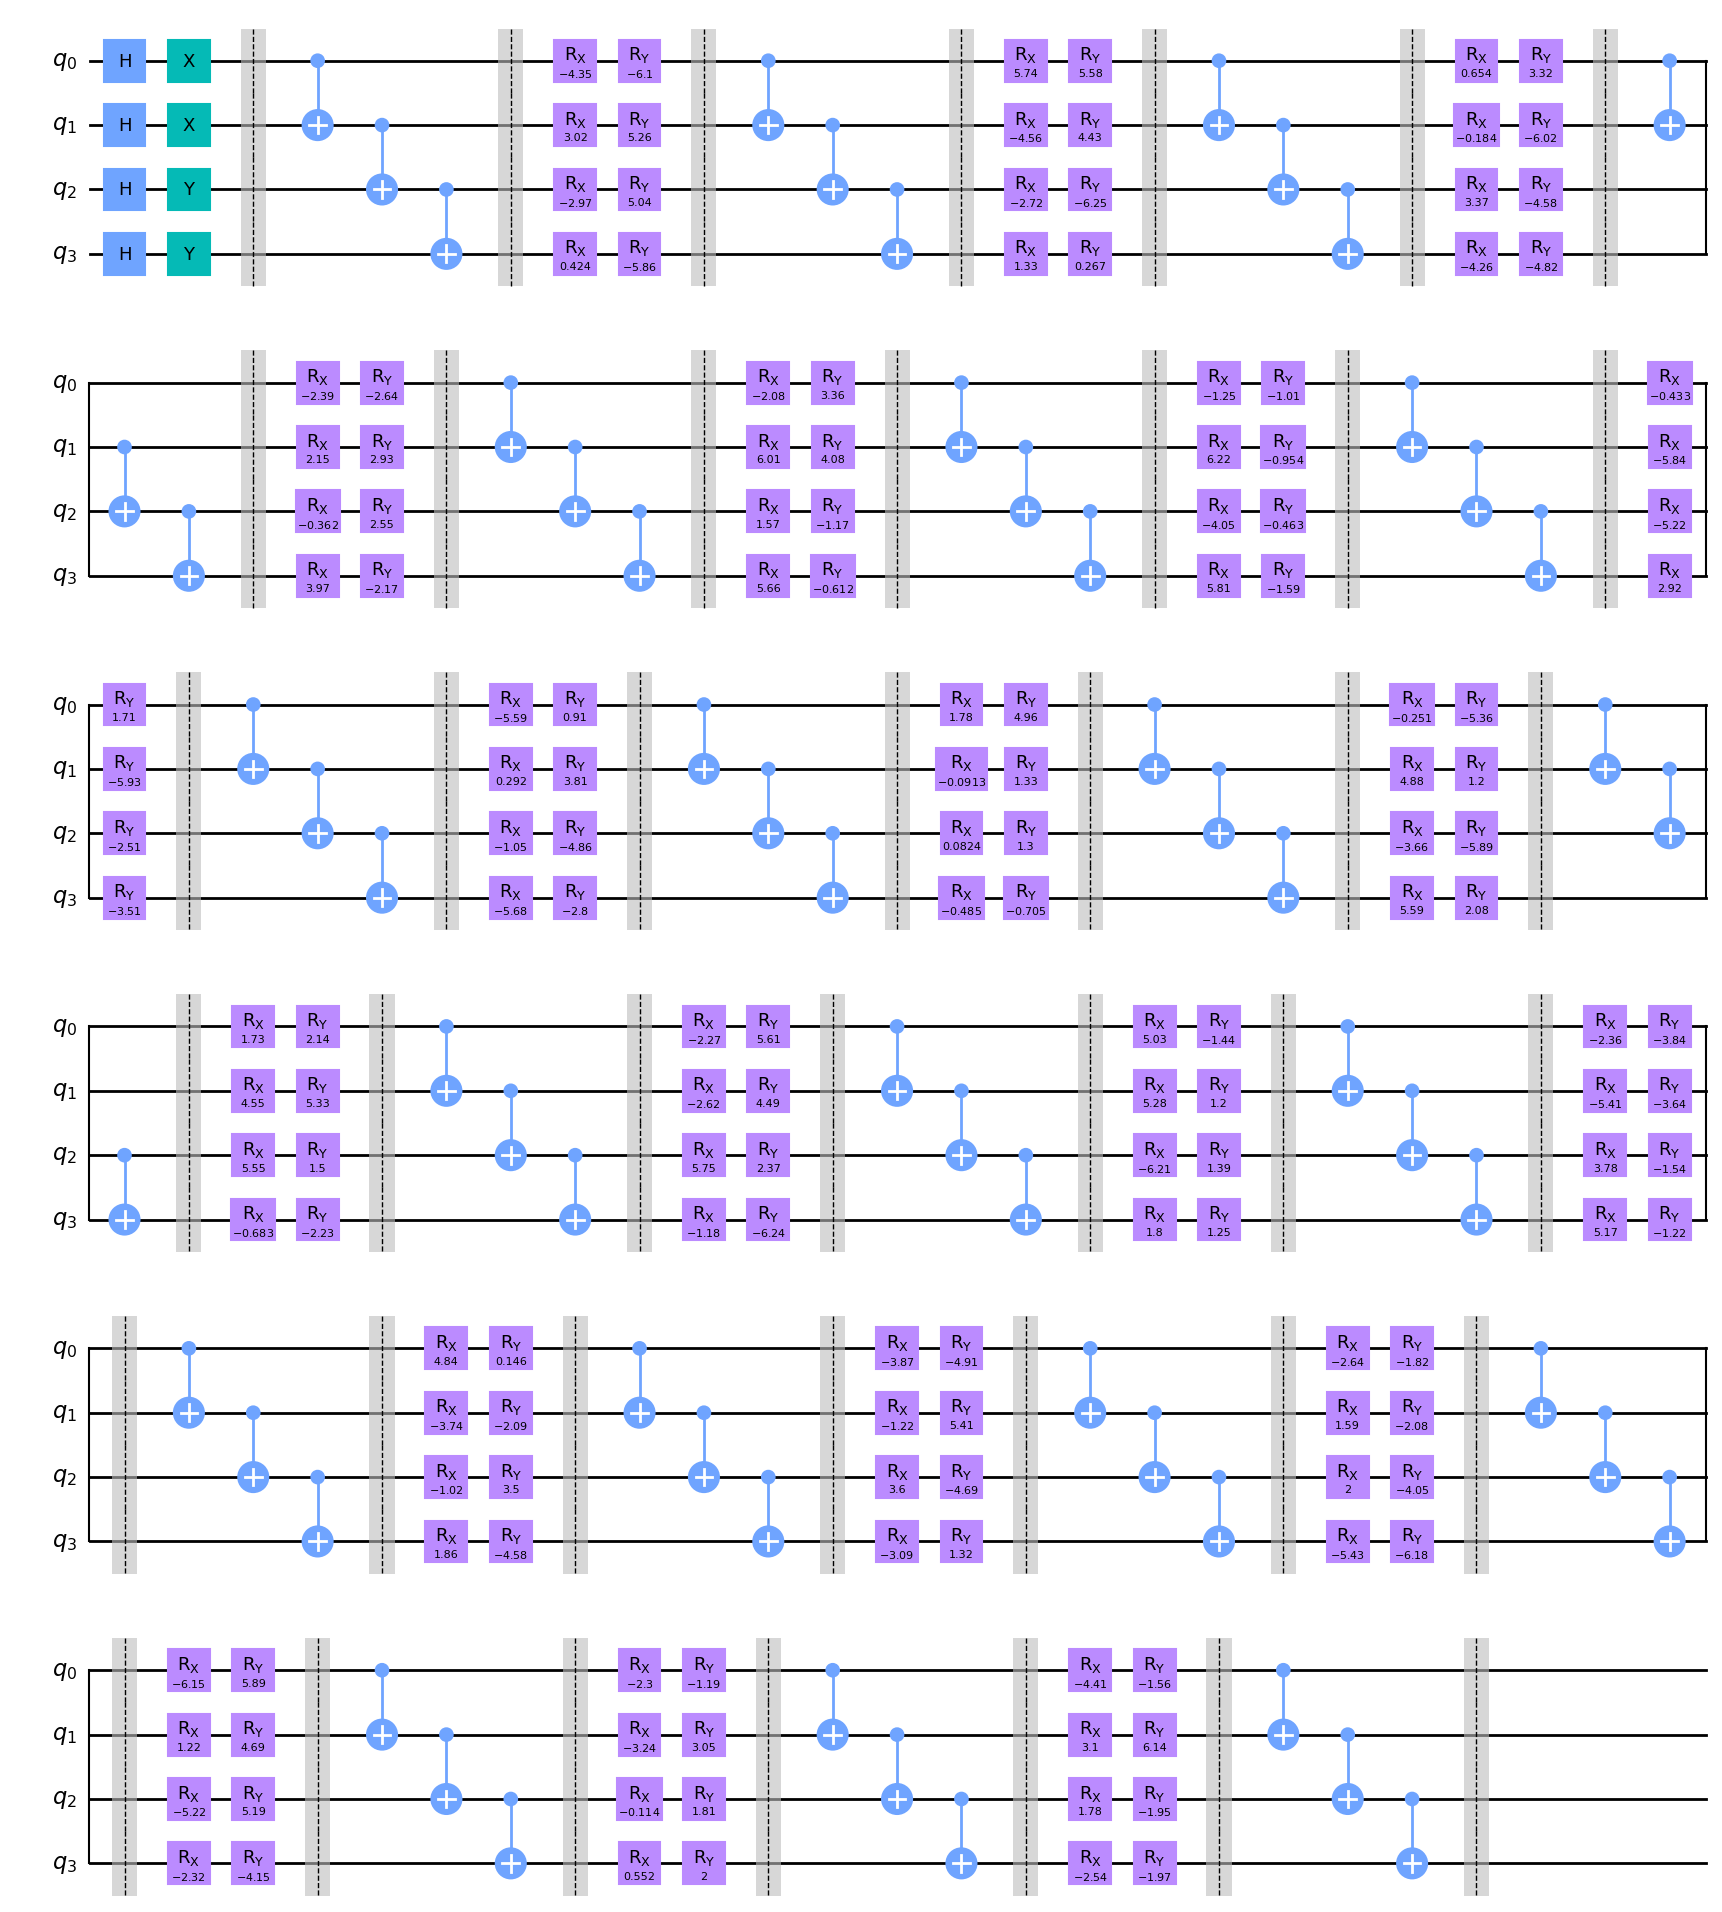

In [23]:
np.random.seed(seed)
circ_simple = qiskit.QuantumCircuit(nqubits)
circ_simple.h(range(nqubits)); 
circ_simple.x(range(nqubits//2)); circ_simple.y(range(nqubits//2, nqubits)); circ_simple.barrier()
for i in range(20):
    circ_simple.cx(range(nqubits-1), range(1,nqubits)); circ_simple.barrier()
    [circ_simple.rx(2*np.pi*(2*np.random.rand(1)[0]-1), i) for i in range(nqubits)]
    [circ_simple.ry(2*np.pi*(2*np.random.rand(1)[0]-1), i) for i in range(nqubits)] ; circ_simple.barrier()
circ_simple.cx(range(nqubits-1), range(1,nqubits)); circ_simple.barrier()
circ_simple.draw('mpl')

In [24]:
circ_simple.count_ops()

OrderedDict([('rx', 80),
             ('ry', 80),
             ('cx', 63),
             ('barrier', 42),
             ('h', 4),
             ('x', 2),
             ('y', 2)])

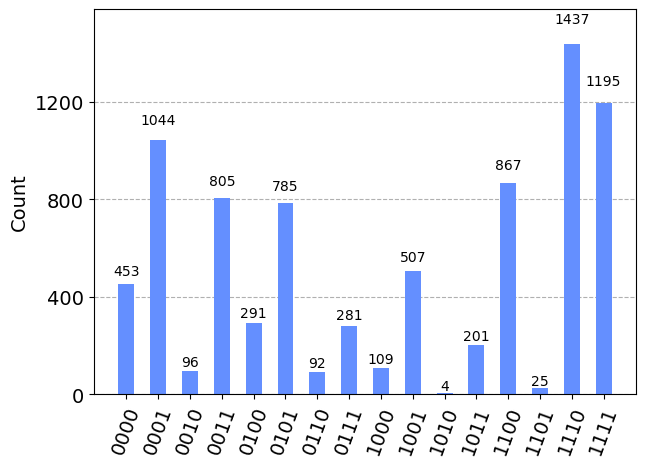

In [25]:
circ_simple.measure_all()
job = qiskit.execute(circ_simple, backend=qiskit.Aer.get_backend('qasm_simulator'),
                     shots=pow(2,13))
results = job.result().get_counts()
plot_histogram(results)

In [26]:
outputfile = conv_resultdict_nparray(results, nqubits) #np.random.permutation(result_array_vec)
outputfile

Result loaded on numpy array! Output shape: (8192, 4)


array([[1., 0., 0., 1.],
       [0., 1., 1., 0.],
       [1., 0., 0., 1.],
       ...,
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [1., 1., 0., 1.]])

In [27]:
n_samples = outputfile.shape[0]
n_samples

8192

# Creating a QeVAE

In [28]:
results

{'1010': 4,
 '1101': 25,
 '1110': 1437,
 '1000': 109,
 '0110': 92,
 '1100': 867,
 '0101': 785,
 '1001': 507,
 '1111': 1195,
 '0001': 1044,
 '0011': 805,
 '0111': 281,
 '1011': 201,
 '0000': 453,
 '0010': 96,
 '0100': 291}

In [29]:
original_results = normalize(results)
original_results

{'1010': 0.00048828125,
 '1101': 0.0030517578125,
 '1110': 0.1754150390625,
 '1000': 0.0133056640625,
 '0110': 0.01123046875,
 '1100': 0.1058349609375,
 '0101': 0.0958251953125,
 '1001': 0.0618896484375,
 '1111': 0.1458740234375,
 '0001': 0.12744140625,
 '0011': 0.0982666015625,
 '0111': 0.0343017578125,
 '1011': 0.0245361328125,
 '0000': 0.0552978515625,
 '0010': 0.01171875,
 '0100': 0.0355224609375}

In [30]:
vals = np.array(list(normalize(results).values()))
#nqubits = datafile.shape[1]
fidelity_uniform_sqrt = np.sum(np.sqrt(vals*(1/pow(2, nqubits))))
print("Fidelity with a uniform distribution:", fidelity_uniform_sqrt**2)

Fidelity with a uniform distribution: 0.7776038252604828


## Create measurement dataloaders

In [31]:
class MeasurementDataset(Dataset):

    def __init__(self, numpy_array:np.ndarray):
        # dataloading
        self.x = torch.from_numpy(numpy_array[:,:])
        self.num_samples = numpy_array.shape[0]


    def __getitem__(self, index):
        # dataset[0]
        return self.x[index].float()

    def __len__(self):
        # len(dataset)
        return self.num_samples

In [32]:
# Setup training and testing datasets

want_datasetsize= 0.05  # can change to 0.2
train_size = 0.75
training_dataset = MeasurementDataset(outputfile[: int(want_datasetsize*train_size * n_samples)])
valid_dataset = MeasurementDataset(outputfile[int(want_datasetsize*train_size * n_samples) : int(want_datasetsize * n_samples)])

train_dataloader = DataLoader(
    training_dataset, batch_size=1, shuffle=True, num_workers=1
)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=1)

dataloaders = [train_dataloader, valid_dataloader]
dataloader_info = "Size of training set: %d | Size of validation set: %d"% (len(train_dataloader), len(valid_dataloader))
print(dataloader_info)

Size of training set: 307 | Size of validation set: 102


# Setup model

## Create model

In [37]:
def create_qnn(num_inputs: int, num_qubits: int, qc_params: dict):
    """Creates the decoder circuit with ansatz"""

    if num_inputs > num_qubits:
        raise ValueError(
            "Number of inputs is greater than the number of qubits... Not suitable with current feature map"
        )

    fm, entanglement_type, repititions = qc_params.values()

    if fm == "ZZ":
        feature_map = qiskit.circuit.library.ZZFeatureMap(num_inputs)
    elif fm == "Z":
        feature_map = qiskit.circuit.library.ZFeatureMap(num_inputs)
    elif fm == 'P':
        feature_map = qiskit.circuit.library.PauliFeatureMap(num_inputs, reps=1, paulis=['X', 'Y'],
                                                             insert_barriers=True)
    else:
        raise ValueError("Wrong feature Map provided!")

    # local_entanglement = {}
    ansatz = qiskit.circuit.library.TwoLocal(
        num_qubits=num_qubits,
        rotation_blocks=["ry", "rx"],
        entanglement_blocks="cx",
        skip_final_rotation_layer=False,
        entanglement=entanglement_type,
        reps=repititions,  # 1
        insert_barriers=True,
    )
    qc = qiskit.QuantumCircuit(num_qubits)
    qc.append(feature_map, range(0, num_inputs))
    qc.h(range(num_inputs, num_qubits)) if num_inputs < num_qubits else None
    qc.barrier()
    qc.append(ansatz, range(num_qubits))
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        sparse=False,
    )
    return qnn, qc

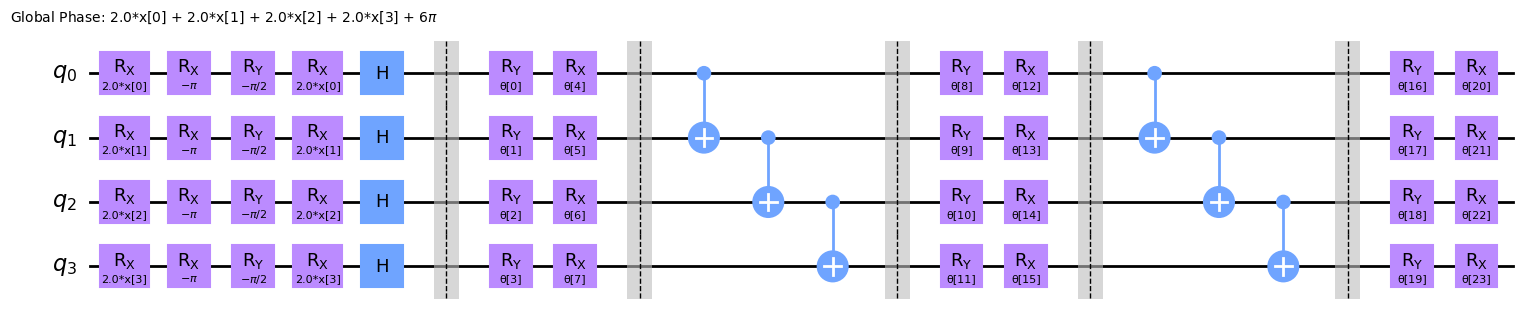

In [38]:
qnn_sample, qnn_qc_sample = create_qnn(num_inputs=4, num_qubits=4, qc_params= {'fm':'Z',
                                                                 'entanglement_type':'linear',
                                                                  'repititions':2})
tc_qc_sample = qiskit.transpile(qnn_qc_sample, basis_gates=['h','rx','ry','cx'])
                                
tc_qc_sample.draw('mpl')

In [39]:
print("Original circuit number of operations: ", circ_simple.count_ops())
print("Ansatz circuit number of operations: ", tc_qc_sample.count_ops())

Original circuit number of operations:  OrderedDict([('rx', 80), ('ry', 80), ('cx', 63), ('barrier', 43), ('h', 4), ('measure', 4), ('x', 2), ('y', 2)])
Ansatz circuit number of operations:  OrderedDict([('rx', 24), ('ry', 16), ('cx', 6), ('barrier', 5), ('h', 4)])


In [40]:
class QVAE_qcompile(torch.nn.Module):

    def __init__(self, qnn, latent_dim:int):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(qnn.circuit.num_qubits, 8),
            torch.nn.LeakyReLU(0.01),
            torch.nn.Linear(8, 7),
            torch.nn.LeakyReLU(0.01)) 

        self.z_mean = torch.nn.Linear(7,latent_dim)
        self.z_log_var = torch.nn.Linear(7,latent_dim)

        # self.preprocessor = torch.nn.Sequential(
        #     torch.nn.Linear(latent_dim, qnn.circuit.num_qubits),
        #     torch.nn.LeakyReLU(0.01))
        
        self.preprocessor = torch.nn.Linear(latent_dim, qnn.circuit.num_qubits)
        torch.nn.init.normal_(self.preprocessor.weight, mean=0, std=0.01)
        torch.nn.init.constant_(self.preprocessor.bias, val=0)
            
        self.decoder = TorchConnector(qnn)

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def decoding_fn(self, x):
        x = self.preprocessor(x)
        decoded = self.decoder(x)
        return decoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1))
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        preprocessed = self.preprocessor(encoded)
        decoded = self.decoder(preprocessed)
        return encoded, z_mean, z_log_var, decoded #preprocessed

In [41]:
class Decoder_distribution():
    """Get distribution by sampling latent space of classial or quantum VAE"""

    def __init__(self, model, original_results:dict, nn_type:str, nsamples:int):
        self.model = model
        self.original_results = normalize(original_results) # set sum frequency = 1
        self.nsamples = nsamples
        self.nn_type = nn_type

    def get_outputstate_from_latentspace_CVAE(self) -> str:
        """For classical VAE: Sample from normal(0,1) from latent space and provide a single
        output bitstring"""
        
        self.model.eval()
        with torch.no_grad():
            sample = torch.randn(self.model.z_mean.out_features) # inputs go through preprocessor
            output = self.model.decoding_fn(sample)
            p = torch.rand(output.shape) #np.random.rand(1)[0]
            state = torch.where(output>p, 1, 0)   
            bitstring = np.apply_along_axis("".join, 0, state.numpy().astype(int).astype(str))
        return bitstring

    def get_ouputdict_from_bitstrings(self, output_dict:dict, bitstring:str) -> dict:
        """If Bitstring is present in output dict then increase count by 1, 
        otherwise create new key"""
        if bitstring.item() in output_dict.keys():
            output_dict[bitstring.item()] += 1
        else:
            output_dict[bitstring.item()] = 1
            #print(bitstring.item())
        return output_dict

    def get_decoder_dist_QVAE(self):
        """For QVAE: Sample from latent space and return marginalised distribution"""
        nqubits = self.model.encoder[0].in_features
        outputs = np.zeros(( self.nsamples, pow(2, nqubits) ))
        with torch.no_grad():
            for idx, _ in enumerate(outputs):
                sample = torch.randn(self.model.z_mean.out_features)
                outputs[idx, :] = self.model.decoding_fn(sample)
        outputs = outputs.mean(axis=0) 
        bitstring_basis = [("{0:0%db}"%nqubits).format(i) for i in range(pow(2, nqubits))]

        return dict(zip(bitstring_basis, outputs))

    def get_fidelity(self, model_output_dict:dict) -> float:
        """Get Bhattacharya co-efficienct of two discrete distributions. 
        The two distributions are normalized (sum of frequencies set to 1) before computation"""
        fidelity_sqrt = 0
        for key in self.original_results.keys():
            if key in model_output_dict.keys():
                fidelity_sqrt += np.sqrt(self.original_results[key]*model_output_dict[key])
        return fidelity_sqrt**2

    def get_no_wrong_samples(self, model_output_dict:dict) -> float:
        """Get the number of wrong samples from the learnt distribution and the mass on right samples
        Wrong sample: bitstring that is not in original_results and has positive probability in learnt distribution"""
        wrong_samples = 0
        for basis_state in model_output_dict.keys():
            if (basis_state not in self.original_results) & (model_output_dict[basis_state] != 0):
                wrong_samples += 1 
        return wrong_samples

    def get_mass_rightsamples(self, model_output_dict:dict) -> float:
        """Get mass of right samples
        Sum of masses in learnt distribution that is on the basis seen in the original dist"""
        mass_right_samples = 0
        for basis_state in self.original_results:
            if basis_state in model_output_dict.keys():
                mass_right_samples += self.original_results[basis_state]
        return mass_right_samples

    def get_decoder_distribution(self):
        """Get distribution from decoder"""
        #output_states = np.zeros((self.nsamples, self.model.decoder[0].in_features))
        
        with torch.no_grad():
            if self.nn_type == "classical":
                output_dict = {}
                for i in range(self.nsamples):
                    bitstring = self.get_outputstate_from_latentspace_CVAE()
                    output_dict = self.get_ouputdict_from_bitstrings(output_dict, bitstring)
                
            elif self.nn_type == "quantum-classical":
                output_dict = self.get_decoder_dist_QVAE()
        
        output_dict = normalize(output_dict)
        no_wrong_samples = self.get_no_wrong_samples(output_dict)
        mass_right_samples = self.get_mass_rightsamples(output_dict)
        fidelity = self.get_fidelity(output_dict)
        return output_dict, no_wrong_samples, mass_right_samples, fidelity 

## Setup training loop

In [42]:
# Set simulation parameters

nqubits=4
featuremap = "P"
patience = 7
minibatchsize=32
beta = 1
latentsize=4
annealing_schedule = 'fixed' # stepfn, linear, fixed, zero, stepfn_linear
nn_type= "quantum-classical" # quantum-classical, classical

encoder_lr = 0.004; decoder_lr = 0.009
learning_rates = [encoder_lr, decoder_lr]

num_epochs = 50
# root_dir = os.path.join(project_dir, "log-files/Quantumcircuit-states")
# print(true_results)

In [43]:
model = QVAE_qcompile(qnn_sample, latent_dim=4)

In [44]:
optimizer = torch.optim.Adam(
    [
        {"params":model.encoder.parameters(), "lr":encoder_lr},
     {"params":model.z_mean.parameters(), "lr":encoder_lr}, 
    {"params":model.z_log_var.parameters(), "lr":encoder_lr},
    {"params":model.preprocessor.parameters(), "lr":encoder_lr},
    {"params":model.decoder.parameters(), "lr":decoder_lr}
])

In [45]:
# Print number of trainable parameters
encoder_trainable_params = sum(
    p.numel() for p in model.encoder.parameters() if p.requires_grad
)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

trainparams_info = "No of trainable parameters: \n (Model:%d) | (Encoder:%d) | (Decoder:%d)"%(trainable_params,
                                                                                              encoder_trainable_params,
                                                                                              qnn_sample.num_weights)
epoch_batch_info = "Total number of epochs: %d | Total number of batches: %d"%(num_epochs,
                                                                               math.ceil(len(dataloaders[0])/minibatchsize))

print(trainparams_info,'\n',epoch_batch_info)

No of trainable parameters: 
 (Model:211) | (Encoder:103) | (Decoder:24) 
 Total number of epochs: 50 | Total number of batches: 10


### Start training

In [46]:
logdict = {"train_combined_loss_per_minibatch": [],
            "train_reconstruction_loss_per_minibatch": [],
            "train_kl_loss_per_minibatch": [],
            "valid_reconstruction_loss": []}

all_bitstrings = [("{0:0%db}"%nqubits).format(i) for i in range(pow(2, nqubits))]
output_qubits = 4

decoder_params_list = []
no_wrong_samples,right_samples_mass,output_dict_list, fidelity_list = [],[],[],[]

In [47]:
def validation_loss(model, valid_dataloader, all_bitstrings):

    output_qubits = model.encoder[0].in_features
    total_val_loss = 0

    with torch.no_grad():
        for idx, data in enumerate(valid_dataloader):
            encoded, z_mean, z_log_var, decoded = model(data)
            input_bitstring = np.apply_along_axis("".join, 1, data.detach().numpy().astype(int).astype(str))
            meas_dict = dict(zip(all_bitstrings,(decoded.squeeze() + pow(2, -18))/ (1 + pow(2, -18) * pow(2, output_qubits)),))
            likelihood_losses = -torch.log(meas_dict[input_bitstring[0]])
            total_val_loss += likelihood_losses

        return total_val_loss / len(valid_dataloader)

In [48]:
loss_list = []

# Early stopping
last_loss = 20
init_mass_rightsamples = 0
trigger_times = 0

for epoch in range(num_epochs):
    total_loss = []
    epoch_kl_loss = []
    epoch_mse_loss = []

    kl_term_weight = beta
    minibatchsize_no = 0
    start_time = time.time()

    for batch_idx, data in enumerate(train_dataloader):

        # Forward pass
        encoded, z_mean, z_log_var, decoded = model(data)
        input_bitstring = np.apply_along_axis("".join, 1, data.numpy().astype(int).astype(str))
        measurement_dict = dict(zip(all_bitstrings,(decoded.squeeze() + pow(2, -18))
                            / (1 + pow(2, -18) * pow(2, output_qubits)),))
        likelihood_losses = -torch.log(measurement_dict[input_bitstring[0]])

        # Normalize loss for batch accumulation
        mean_ll = likelihood_losses / minibatchsize
        kl_loss = -0.5 * torch.sum(
            1 + z_log_var - z_mean ** 2 - torch.exp(z_log_var)
        )
        kl_loss = (kl_term_weight * kl_loss) / minibatchsize
        loss = mean_ll + kl_loss

        # Backward pass
        loss.backward()

        # weights update
        if ((batch_idx + 1) % minibatchsize == 0) or (batch_idx + 1 == len(train_dataloader)):
            minibatchsize_no += 1
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)  # reset gradients to zero

            # Store losses
            total_loss.append(loss.item())
            epoch_mse_loss.append(mean_ll.item())
            epoch_kl_loss.append(kl_loss.item())

            print(
                "(%d|%d , %d|%d) Total loss: %.5f | Likelihood loss: %.5f | KL loss : %.5f "
                % (epoch + 1,num_epochs,minibatchsize_no,
                    math.ceil(len(train_dataloader) /minibatchsize),
                    loss.item(),mean_ll.item(),kl_loss.item(),))

            # LOGGING
            logdict["train_combined_loss_per_minibatch"].append(loss.item())
            logdict["train_reconstruction_loss_per_minibatch"].append(mean_ll.item())
            logdict["train_kl_loss_per_minibatch"].append(kl_loss.item())

    end_time = time.time()
    valid_loss = validation_loss(model, valid_dataloader, all_bitstrings)
    logdict["valid_reconstruction_loss"].append(valid_loss)


    decoder_params = model.decoder.weight.detach().numpy().copy()
    encoder_params = [param.detach().numpy().tolist() for param in model.encoder.parameters()]
    decoder_params_list.append(decoder_params)

    output_dist = Decoder_distribution(model, original_results, nn_type='quantum-classical', nsamples=5000)
    (output_dict,n_wrong_samples,mass_right_samples,fidelity) = output_dist.get_decoder_distribution()

    no_wrong_samples.append(n_wrong_samples)
    right_samples_mass.append(mass_right_samples)
    output_dict_list.append(output_dict)
    fidelity_list.append(fidelity)
    print("Fidelity:", fidelity)

    # Store loss for epoch
    loss_list.append(sum(total_loss) / len(total_loss))

    print("Time taken %4fs" % (end_time - start_time))
    print("Epoch: %02d/%02d | Beta %.3f | Avg Train Loss: %.4f | Valid Loss: %.4f | Wrong states: %d | Mass on right states %.4f\n"
        %(epoch + 1,num_epochs,kl_term_weight,loss_list[-1],
            valid_loss,n_wrong_samples,mass_right_samples,))

    if valid_loss > last_loss:  # mass_right_samples < init_mass_rightsamples:
        trigger_times += 1
        #trigger_vals.append(trigger_times)
        print(f"Trigger Times: {trigger_times} \n")

        if trigger_times >= patience:
            print("Early stopping! Closing training. Now can start to test process.")
            break
        
    elif valid_loss <= last_loss:  
        # mass_right_samples >= init_mass_rightsamples:
        print("Trigger times: 0\n")
        trigger_times = 0
        last_loss = valid_loss

(1|50 , 1|10) Total loss: 0.10218 | Likelihood loss: 0.09901 | KL loss : 0.00317 
(1|50 , 2|10) Total loss: 0.14218 | Likelihood loss: 0.13900 | KL loss : 0.00319 
(1|50 , 3|10) Total loss: 0.12214 | Likelihood loss: 0.11983 | KL loss : 0.00231 
(1|50 , 4|10) Total loss: 0.09490 | Likelihood loss: 0.09274 | KL loss : 0.00215 
(1|50 , 5|10) Total loss: 0.07739 | Likelihood loss: 0.07576 | KL loss : 0.00163 
(1|50 , 6|10) Total loss: 0.04894 | Likelihood loss: 0.04645 | KL loss : 0.00249 
(1|50 , 7|10) Total loss: 0.10500 | Likelihood loss: 0.10380 | KL loss : 0.00120 
(1|50 , 8|10) Total loss: 0.05378 | Likelihood loss: 0.05167 | KL loss : 0.00211 
(1|50 , 9|10) Total loss: 0.08561 | Likelihood loss: 0.08451 | KL loss : 0.00111 
(1|50 , 10|10) Total loss: 0.08877 | Likelihood loss: 0.08779 | KL loss : 0.00098 
Fidelity: 0.7520213772364683
Time taken 39.219177s
Epoch: 01/50 | Beta 1.000 | Avg Train Loss: 0.0921 | Valid Loss: 2.9367 | Wrong states: 0 | Mass on right states 1.0000

Trigger

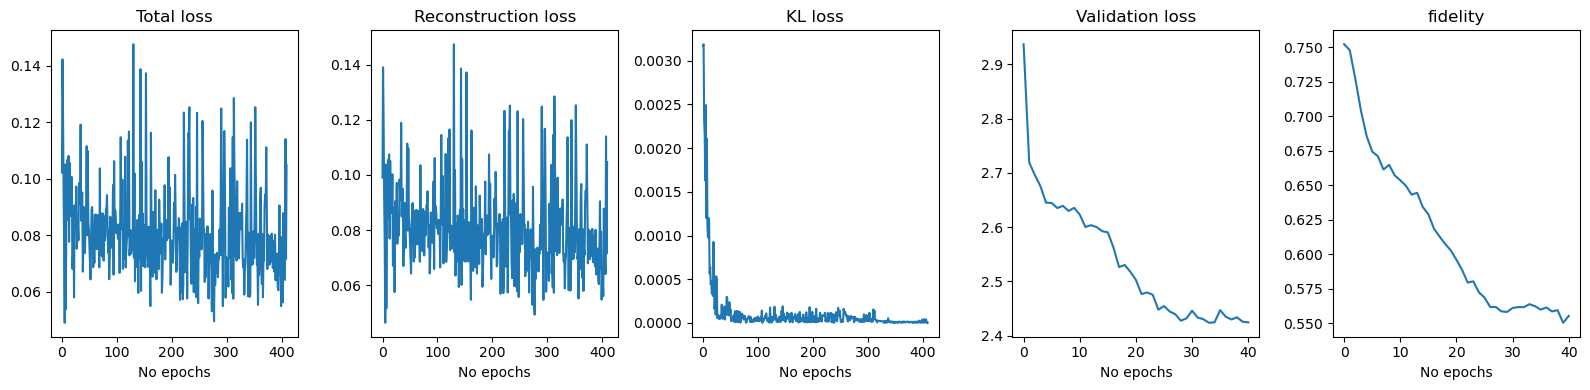

In [49]:
fig, ax = plt.subplots(1, 5, figsize=(16,4))

titles=['Total loss', 'Reconstruction loss', 'KL loss', 'Validation loss']
for idx, (key, value) in enumerate(logdict.items()):
    ax[idx].plot(value)
    ax[idx].set(title=titles[idx], xlabel="No epochs")

ax[4].plot(fidelity_list)
ax[4].set(title="fidelity", xlabel="No epochs")

plt.tight_layout()
plt.show()

In [50]:
n_samples = 1000
random_samples = torch.randn(n_samples, 4)
output_dist = np.zeros((n_samples, pow(2,4)))

for idx, sample in enumerate(random_samples):
    with torch.no_grad():
        processed_sample = model.preprocessor(sample)
        output_dist[idx, :] = model.decoder(processed_sample)

In [51]:
original_results

orig_dist_sorted = []
for bitstring in all_bitstrings:
    orig_dist_sorted.append(original_results[bitstring])

In [52]:
final_fidelity = 0
for idx in range(16):
    final_fidelity += np.sqrt(orig_dist_sorted[idx]*output_dist.mean(axis=0)[idx])
final_fidelity = final_fidelity**2

print("Learnt distribution fidelity:", final_fidelity)

Learnt distribution fidelity: 0.555493954070672


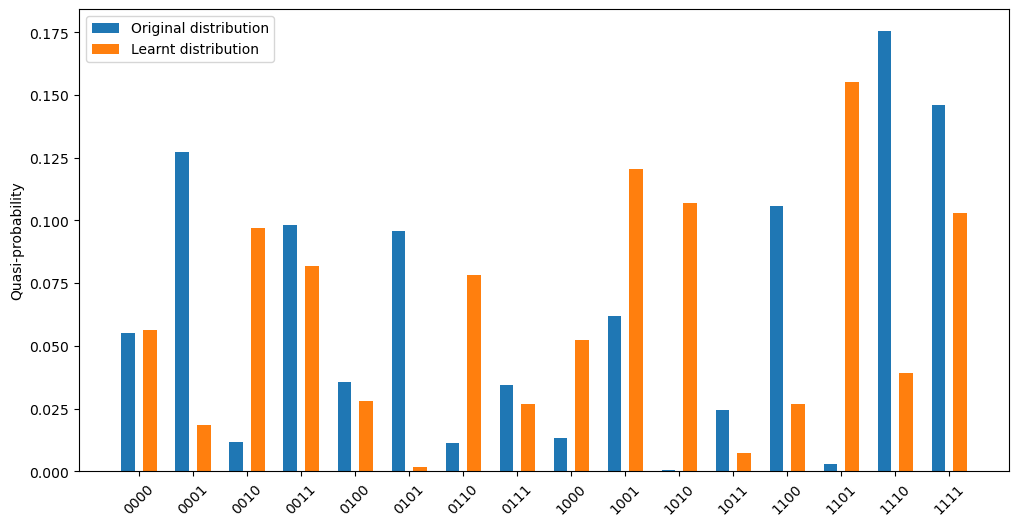

In [53]:
plt.bar(np.arange(16)-0.2, orig_dist_sorted, width=0.25, label="Original distribution")
plt.bar(np.arange(16)+0.2, output_dist.mean(axis=0), width=0.25, label="Learnt distribution")

plt.legend()
plt.xticks(np.arange(16), all_bitstrings, rotation=45)
plt.ylabel("Quasi-probability")
plt.show()

In [54]:
# The parameters of the ansatz the yield the same measurement distribution are: 
list(model.decoder.parameters())


[Parameter containing:
 tensor([ 0.8083,  0.1096, -0.3322,  0.5447,  0.9371,  0.5336,  0.5533, -0.5389,
         -0.4891, -0.5514, -0.0241, -0.1254,  0.1623, -1.4390, -0.2003, -1.1516,
          0.9507, -0.9245,  0.3164,  0.6064,  0.2651,  0.2774, -0.5184, -0.4813],
        requires_grad=True)]

# References
1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test